In [ ]:
import os
import cv2
import copy
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
import random
import torch
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from scipy.stats import kurtosis, skew
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.activation import ReLU
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import kurtosis, skew
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import pickle
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.optim as optim
from tqdm import tqdm
from google.colab import drive
from pathlib import Path
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, ADASYN,RandomOverSampler

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Directories
input_directory = '/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem Preprocessed'
train_directory = input_directory+'/train' 
val_directory = input_directory+'/val'

In [ ]:
#Training set organization
train_bcc_aug= sorted(glob(os.path.join(train_directory, "bcc", "*.jpg")))
train_mel_aug= sorted(glob(os.path.join(train_directory, "mel", "*.jpg")))
train_scc_aug= sorted(glob(os.path.join(train_directory, "scc", "*.jpg")))
tags_bcc_train=[]
tags_mel_train=[]
tags_scc_train=[]
tags_train=[]
images_bcc=[]
images_mel=[]
images_scc=[]
labels_bcc=[]
labels_mel=[]
labels_scc=[]

In [ ]:
#Validation set organization
train_bcc_val= sorted(glob(os.path.join(val_directory, "bcc", "*.jpg")))
train_mel_val= sorted(glob(os.path.join(val_directory, "mel", "*.jpg")))
train_scc_val= sorted(glob(os.path.join(val_directory, "scc", "*.jpg")))
tags_bcc_val=[]
tags_mel_val=[]
tags_scc_val=[]
tags_val=[]
images_bcc_val=[]
images_mel_val=[]
images_scc_val=[]
labels_bcc_val=[]
labels_mel_val=[]
labels_scc_val=[]

In [ ]:
train_bcc = []
train_mel = []
train_scc = []
for bcc in train_bcc_aug:
  if 'aug' not in bcc:
    train_bcc.append(bcc)
for mel in train_mel_aug:
  if 'aug' not in mel:
    train_mel.append(mel)
for scc in train_scc_aug:
  if 'aug' not in scc:
    train_scc.append(scc)

In [ ]:
print(len(train_bcc))
print(len(train_mel))
print(len(train_scc))
print(len(train_bcc_val))
print(len(train_mel_val))
print(len(train_scc_val))

1993
2713
376
498
678
94


In [ ]:
#Training set DataFrame construction
for i in range(len(train_mel)):
  tags_mel_train.append(train_mel[i][-12:])
  labels_mel.append(0)
for i in range(len(train_bcc)):
  tags_bcc_train.append(train_bcc[i][-12:])
  labels_bcc.append(1)
for i in range(len(train_scc)):
  tags_scc_train.append(train_scc[i][-12:])
  labels_scc.append(2)

In [ ]:
#Validation set DataFrame construction
for i in range(len(train_mel_val)):
  tags_mel_val.append(train_mel_val[i][-12:])
  labels_mel_val.append(0)
for i in range(len(train_bcc_val)):
  tags_bcc_val.append(train_bcc_val[i][-12:])
  labels_bcc_val.append(1)
for i in range(len(train_scc_val)):
  tags_scc_val.append(train_scc_val[i][-12:])
  labels_scc_val.append(2)

In [ ]:
tags_train= tags_bcc_train + tags_mel_train + tags_scc_train
X_train= labels_bcc+labels_mel+labels_scc

In [ ]:
tags_val= tags_bcc_val + tags_mel_val+tags_scc_val
X_test= labels_bcc_val +labels_mel_val+labels_scc_val

In [ ]:
training_set= pd.DataFrame.from_dict({'Image Tag':tags_train, 'Image Route': train_bcc+train_mel+train_scc, 'Label': X_train})
valid_set= pd.DataFrame.from_dict({'Image Tag':tags_val, 'Image Route': train_bcc_val+train_mel_val+train_scc_val, 'Label': X_test})

In [ ]:
X_train_data= training_set['Image Route'].to_numpy()
y_train_data= training_set['Label'].to_numpy()
X_test_data= valid_set['Image Route'].to_numpy()
y_test_data= valid_set['Label'].to_numpy()

In [ ]:
X_train,y_train = shuffle(X_train_data,y_train_data, random_state= 42)
X_test,y_test= shuffle(X_test_data, y_test_data, random_state=42)

In [ ]:
def color_histogram_features(imr):
  color_histogram=[]
  for i in imr:
    image_read= cv2.imread(i)
    bgr= cv2.split(image_read)
    histSize=64
    histRange=(0,256)
    accumulate= False 
    b_hist = cv2.calcHist(bgr, [0], None, [histSize], histRange)
    g_hist = cv2.calcHist(bgr, [1], None, [histSize], histRange)
    r_hist = cv2.calcHist(bgr, [2], None, [histSize], histRange)
    bgr_hist= np.concatenate((b_hist,g_hist,r_hist),axis=None).T
    color_histogram.append(bgr_hist)
  
  features_color_histogram= pd.DataFrame(color_histogram)
  
  return features_color_histogram

In [ ]:
X_train_features= color_histogram_features(X_train)
X_test_features= color_histogram_features(X_test)
scaler= StandardScaler().fit(X_train_features)
X_train_scaled= scaler.transform(X_train_features)
X_test_scaled= scaler.transform(X_test_features)

In [ ]:
X_train_features.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/Smote_Train_HistogramColorFeatures291022.csv',index=False)
X_test_features.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/Smote_Test_HistogramColorFeatures291022.csv',index=False)

In [ ]:
#Data Balancing in order to tackle data imbalance. technique used: SMOTE 
ros = SMOTE(sampling_strategy='auto', random_state= 42)
X_train_resampled, y_train_resampled= ros.fit_resample(X_train_scaled,y_train)
print(np.bincount(y_train_resampled))

[2713 2713 2713]


First model: SVM

In [ ]:
model1= svm.SVC()
model1.fit(X_train_resampled, y_train_resampled)
y_pred1= model1.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred1))
print(balanced_accuracy_score(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.87      0.68      0.76       678
           1       0.69      0.68      0.68       498
           2       0.22      0.59      0.32        94

    accuracy                           0.67      1270
   macro avg       0.59      0.65      0.59      1270
weighted avg       0.75      0.67      0.70      1270

0.6471151662445931


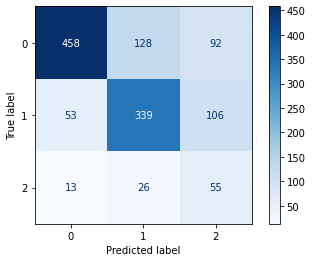

In [ ]:
cm= confusion_matrix(y_test,y_pred1,labels= model1.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Second Model: Logistic Regression

In [ ]:
model2= LogisticRegression(max_iter=2000)
model2.fit(X_train_resampled, y_train_resampled)
y_pred2= model2.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred2))
print(balanced_accuracy_score(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.83      0.56      0.67       678
           1       0.57      0.54      0.55       498
           2       0.12      0.46      0.20        94

    accuracy                           0.54      1270
   macro avg       0.51      0.52      0.47      1270
weighted avg       0.68      0.54      0.59      1270

0.5183765249915749


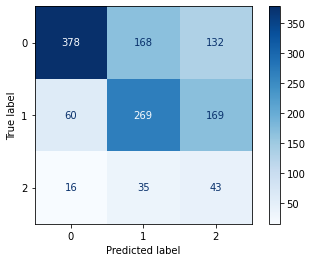

In [ ]:
cm= confusion_matrix(y_test,y_pred2,labels= model2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Third model: Gradient Boosting

In [ ]:
model3= GradientBoostingClassifier(random_state=42)
model3.fit(X_train_resampled, y_train_resampled)
y_pred3= model3.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred3))
print(balanced_accuracy_score(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.87      0.72      0.79       678
           1       0.70      0.73      0.71       498
           2       0.23      0.46      0.31        94

    accuracy                           0.71      1270
   macro avg       0.60      0.64      0.60      1270
weighted avg       0.75      0.71      0.72      1270

0.636714182405893


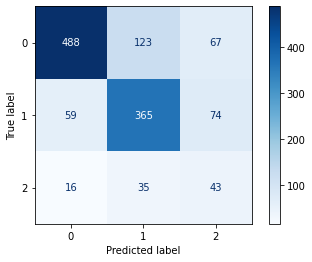

In [ ]:
cm= confusion_matrix(y_test,y_pred3,labels= model3.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fourth Model: Random Forest Classifier

In [ ]:
model4= RandomForestClassifier(random_state=42)
model4.fit(X_train_resampled, y_train_resampled)
y_pred4= model4.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred4))
print(balanced_accuracy_score(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       678
           1       0.74      0.78      0.76       498
           2       0.38      0.38      0.38        94

    accuracy                           0.77      1270
   macro avg       0.66      0.66      0.66      1270
weighted avg       0.77      0.77      0.77      1270

0.6580821497248645


In [ ]:
#pickle.dump(model4, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/BinaryProblem_Data/ColorFeatures_RF_model.sav', 'wb'))

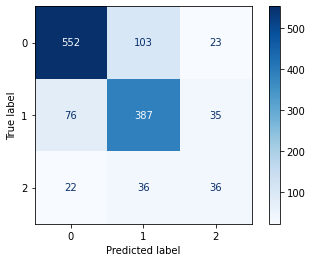

In [ ]:
cm= confusion_matrix(y_test,y_pred4,labels= model4.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fifth model: AdaBoost classifier

In [ ]:
model5= AdaBoostClassifier(random_state=42)
model5.fit(X_train_resampled, y_train_resampled)
y_pred5= model5.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred5))
print(balanced_accuracy_score(y_test,y_pred5))

              precision    recall  f1-score   support

           0       0.83      0.67      0.74       678
           1       0.63      0.64      0.64       498
           2       0.17      0.40      0.24        94

    accuracy                           0.64      1270
   macro avg       0.54      0.57      0.54      1270
weighted avg       0.70      0.64      0.66      1270

0.5698254008943575


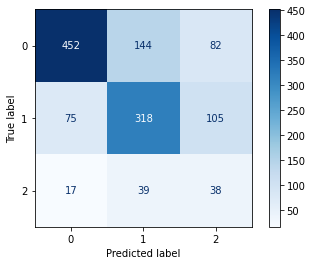

In [ ]:
cm= confusion_matrix(y_test,y_pred5,labels= model5.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model5.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Sixth Model: Decision Trees Classifier

In [ ]:
model6= DecisionTreeClassifier(random_state=42)
model6.fit(X_train_resampled, y_train_resampled)
y_pred6= model6.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred6))
print(balanced_accuracy_score(y_test,y_pred6))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73       678
           1       0.61      0.60      0.61       498
           2       0.20      0.34      0.25        94

    accuracy                           0.63      1270
   macro avg       0.52      0.54      0.53      1270
weighted avg       0.66      0.63      0.64      1270

0.5449947659841651


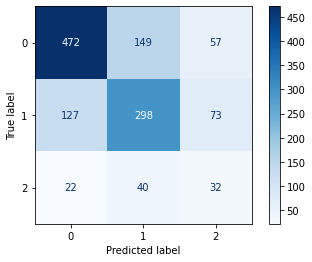

In [ ]:
cm= confusion_matrix(y_test,y_pred6,labels= model6.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model6.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Seventh model: XGBoost Classifier

In [ ]:
model7= XGBClassifier(random_state=42)
model7.fit(X_train_resampled, y_train_resampled)
y_pred7= model7.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred7))
print(balanced_accuracy_score(y_test,y_pred7))

              precision    recall  f1-score   support

           0       0.87      0.71      0.78       678
           1       0.69      0.73      0.71       498
           2       0.21      0.44      0.29        94

    accuracy                           0.69      1270
   macro avg       0.59      0.62      0.59      1270
weighted avg       0.75      0.69      0.71      1270

0.6233668748930322


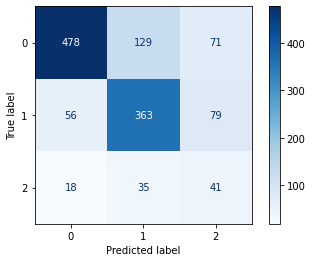

In [ ]:
cm= confusion_matrix(y_test,y_pred7,labels= model7.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model7.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eigth model: Naive Bayes Classifier

In [ ]:
model8= GaussianNB()
model8.fit(X_train_resampled, y_train_resampled)
y_pred8= model8.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred8))
print(balanced_accuracy_score(y_test,y_pred8))

              precision    recall  f1-score   support

           0       0.85      0.36      0.51       678
           1       0.46      0.20      0.28       498
           2       0.10      0.81      0.18        94

    accuracy                           0.33      1270
   macro avg       0.47      0.46      0.32      1270
weighted avg       0.64      0.33      0.39      1270

0.45773730710200367


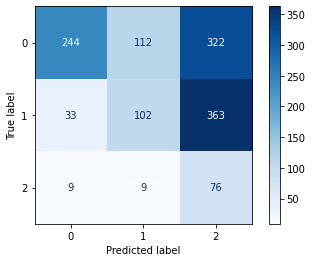

In [ ]:
cm= confusion_matrix(y_test,y_pred8,labels= model8.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model8.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Ninth Model: KNeighbors Classifier

In [ ]:
model9= KNeighborsClassifier()
model9.fit(X_train_resampled, y_train_resampled)
y_pred9= model9.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred9))
print(balanced_accuracy_score(y_test,y_pred9))

              precision    recall  f1-score   support

           0       0.85      0.65      0.74       678
           1       0.69      0.66      0.67       498
           2       0.23      0.66      0.34        94

    accuracy                           0.65      1270
   macro avg       0.59      0.66      0.58      1270
weighted avg       0.74      0.65      0.68      1270

0.6562171613712743


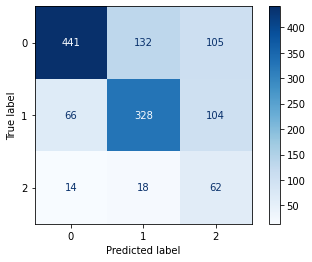

In [ ]:
cm= confusion_matrix(y_test,y_pred9,labels= model9.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model9.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Tenth Model: Bagging Classifier

In [ ]:
model10= BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),n_estimators=10,random_state=42)
model10.fit(X_train_resampled, y_train_resampled)
y_pred10= model10.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred10))
print(balanced_accuracy_score(y_test,y_pred10))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       678
           1       0.74      0.77      0.75       498
           2       0.34      0.43      0.38        94

    accuracy                           0.76      1270
   macro avg       0.65      0.67      0.65      1270
weighted avg       0.77      0.76      0.77      1270

0.6663253780829714


In [ ]:
#pickle.dump(model10, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/BinaryProblem_Data/ColorFeatures_Bagging_model.sav', 'wb'))

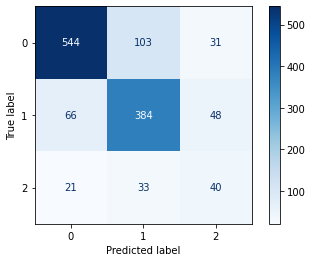

In [ ]:
cm= confusion_matrix(y_test,y_pred10,labels= model10.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model10.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eleventh Model: Stacking Classifier

In [ ]:
def get_stack_model():
  level0 = list()
  level0.append(('lr', LogisticRegression(max_iter=2000,random_state=42)))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('cart', DecisionTreeClassifier(random_state=42)))
  level0.append(('svm', svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr', random_state=42)))
  level0.append(('bayes', GaussianNB()))
  level0.append(('gboosting', GradientBoostingClassifier(random_state=42)))
  level0.append(('rforest', RandomForestClassifier(random_state=42)))
  level0.append(('adaboost', AdaBoostClassifier(random_state=42)))
  level1 = LogisticRegression(max_iter=2000,random_state=42)
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

In [ ]:
model11=get_stack_model()
model11.fit(X_train_resampled, y_train_resampled)
y_pred11= model11.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred11))
print(balanced_accuracy_score(y_test,y_pred11))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       678
           1       0.75      0.80      0.77       498
           2       0.55      0.34      0.42        94

    accuracy                           0.79      1270
   macro avg       0.71      0.66      0.68      1270
weighted avg       0.78      0.79      0.78      1270

0.6612296168922221


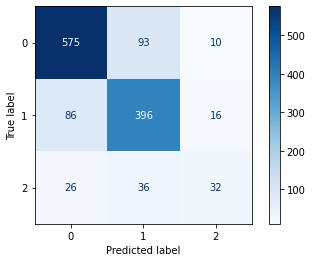

In [ ]:
cm= confusion_matrix(y_test,y_pred11,labels= model11.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model11.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()